# Retirement Planner

---

## Environment Setup

In [26]:
# Import libraries and dependencies
import numpy as np
import pandas as pd
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
%matplotlib inline


In [27]:
# Set the random seed for resutls reproducibility (for testing purposes only)
np.random.seed(42)

---

## Portfolio Planner

In this activity, you will use the Alpaca API to grab historical data for a `60/40` portfolio using `SPY` to represent the stock portion and `AGG` to represent the bonds.

In [28]:
# Load .env enviroment variables
from dotenv import load_dotenv
load_dotenv()

# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Create the Alpaca API object
api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")

# Data Collection

In this step, you will need to use the Alpaca api to fetch closing prices for the `SPY` and `AGG` tickers. Save the results as a pandas DataFrame

In [29]:
# Subset your tickers, then pull returns data:
# Set the ticker
ticker = ["SPY", "AGG"]

# Set timeframe to '1D'
timeframe = "1D"

# Set start and end datetimes of 1 year, between now and 365 days ago.
start_date = pd.Timestamp('2019-01-01', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2019-12-31', tz='America/New_York').isoformat()

# Get 1 year's worth of historical data for SPY and AGG
df = api.get_barset(
    ticker,
    timeframe,
    limit=None,
    start=start_date,
    end=end_date,
    after=None,
    until=None,
).df

# Drop unnecessary columns
df = df.drop(
    columns=['open', 'high', 'low', 'volume'],
    level=1
)

columns = ['AGG','SPY']
df.columns = columns
df.head()

,AGG,SPY
2019-01-02 00:00:00-05:00,106.585,249.89
2019-01-03 00:00:00-05:00,107.020,244.46
2019-01-04 00:00:00-05:00,106.695,252.41
2019-01-07 00:00:00-05:00,106.470,254.40
2019-01-08 00:00:00-05:00,106.420,256.65


In [30]:
# Display sample data
df.index = df.index.date
df.iloc[[0, -1]]


,AGG,SPY
2019-01-02,106.585,249.89
2019-12-31,112.370,321.89


---

## Monte Carlo Simulation

In this step, you will run Monte Carlo Simulations for your portfolio to model portfolio performance at different retirement ages. 

Complete the following steps:

1. Calculate the daily returns for the SPY and AGG closing prices.

2. Calculate volatility for both the SPY and AGG closing prices.

3. Find the last day's closing price for both stocks and save those as variables

4. Run a Monte Carlo Simulation of at least `100` iterations and generate at least `30` years of closing prices

**Hint:** There are `252` trading days per year, so the number of records to generate for each Monte Carlo run will be `252 days * 30 years`.

In [31]:
# Calculate the daily return for the stocks
daily_returns = df.pct_change().dropna()
# Display sample data
daily_returns.head()

,AGG,SPY
2019-01-03,0.004081,-0.021730
2019-01-04,-0.003037,0.032521
2019-01-07,-0.002109,0.007884
2019-01-08,-0.000470,0.008844
2019-01-09,0.000564,0.004130


In [32]:
for col in df.columns: 
    print(col) 

AGG
SPY


In [33]:
# Compute daily volatility & average daily returns
avg_daily_return_agg = daily_returns.mean()['AGG']
avg_daily_return_spy = daily_returns.mean()['SPY']

std_dev_daily_return_agg = daily_returns.std()['AGG']
std_dev_daily_return_spy = daily_returns.std()['SPY']


In [34]:
# Save the last day's closing price
agg_last_price = df['AGG'][-1]
spy_last_price = df['SPY'][-1]

print(agg_last_price)
print(spy_last_price)

112.37
321.89


In [35]:
# Setup the Monte Carlo Parameters
num_simulations = 500
num_trading_days = 252 * 30

In [36]:
# Run Monte Carlo Simulation

# Initialize empty DataFrame to hold simulated prices for each simulation
simulated_price_df = pd.DataFrame()
portfolio_cumulative_returns = pd.DataFrame()

# Initialize the simulated prices list with the last closing price of `AGG` and `SPY`
for simulation in range(num_simulations):
    
    simulated_agg_prices = [agg_last_price]
    simulated_spy_prices = [spy_last_price]

# Simulate the returns for 252 * 30 trading days (30 years)
    for day in range(num_trading_days):
        # Calculate the simulated price using the last price within the list
        simulated_agg_price = simulated_agg_prices[-1] * (1 + np.random.normal(avg_daily_return_agg, std_dev_daily_return_agg))
        simulated_spy_price = simulated_spy_prices[-1] * (1 + np.random.normal(avg_daily_return_spy, std_dev_daily_return_spy))
    
        # Append the simulated price to the list
        simulated_agg_prices.append(simulated_agg_price)
        simulated_spy_prices.append(simulated_spy_price)
    
    # Append the simulated prices of each simulation to respective DataFrame
    simulated_price_df['AGG prices']=pd.Series(simulated_agg_prices)
    simulated_price_df['SPY prices']=pd.Series(simulated_spy_prices)

    # Calculate the daily returns of simulated prices
    simulated_daily_returns = simulated_price_df.pct_change()
    
    # Set the portfolio weights (20% AGG; 80% SPY)
    weights = [0.2, 0.8]
    
    # Multiply weights to determine portfolio's simulated daily returns
    portfolio_daily_returns = simulated_daily_returns.dot(weights)
   
    # Calculate the cumulative return series
    portfolio_cumulative_returns[simulation] = (1 + portfolio_daily_returns.fillna(0)).cumprod()
    
# Valiate DataFrame successful
portfolio_cumulative_returns.head()       

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.000217,1.001362,0.999379,1.007384,1.015202,0.991403,0.994835,1.018614,1.000900,0.993825,...,1.002482,0.990714,1.001348,1.003627,0.995540,1.003826,1.002793,1.010170,0.997039,0.993270
2,1.010894,1.006433,1.005990,0.995685,1.011654,0.992464,0.991527,1.011927,1.000136,0.989370,...,1.007182,0.992059,1.002935,1.008149,0.996675,0.988789,1.004392,1.008190,0.994275,0.998272
3,1.010198,1.005772,1.005685,0.998615,1.009261,0.983057,0.996386,1.004862,1.000164,0.999318,...,1.008545,0.983396,1.003312,1.013889,0.991976,0.992600,1.011321,0.998770,0.997179,1.004500
4,1.016598,1.008519,1.012657,1.003715,1.017080,0.988261,1.003368,0.997263,1.001434,1.007274,...,1.004736,0.988630,1.004338,1.004703,0.993140,0.992126,1.008690,1.002874,0.994188,1.005001


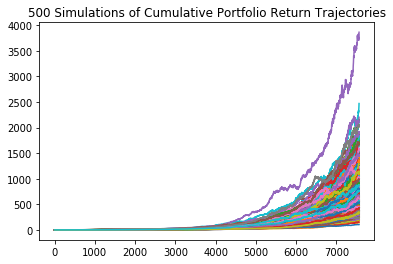

In [37]:
# Visualize the Simulation
plot_title = f"{simulation+1} Simulations of Cumulative Portfolio Return Trajectories"
portfolio_cumulative_returns.plot(legend=None, title=plot_title);

In [38]:
# Select the last row for the cumulative returns (cumulative returns at 20 years)
portfolio_cumulative_returns.iloc[5039]

0       75.680999
1       66.738208
2       59.700556
3       48.479726
4      113.524886
          ...    
495    168.153409
496     99.686004
497    207.614694
498     31.075799
499     96.836420
Name: 5039, Length: 500, dtype: float64

In [39]:
# Select the last row for the cumulative returns (cumulative returns at 30 years)
ending_cumulative_returns = portfolio_cumulative_returns.iloc[-1,:]
ending_cumulative_returns

0       614.319484
1       542.293880
2       540.715848
3       380.832495
4       535.362488
          ...     
495    1672.735214
496     616.964016
497    2012.736945
498     343.858870
499     766.884734
Name: 7560, Length: 500, dtype: float64

In [40]:
# Display the 90% confidence interval for the ending returns
confidence_interval = ending_cumulative_returns.quantile(q=[0.05, 0.95])
confidence_interval

0.05     280.556923
0.95    1549.892798
Name: 7560, dtype: float64

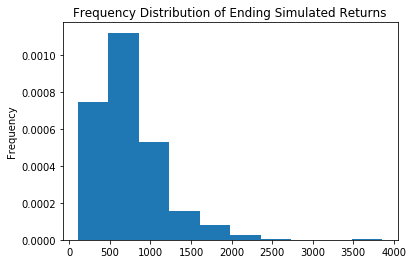

In [41]:
# Visualize the distribution of the ending returns
ending_cumulative_returns.plot(kind='hist',density=True,bins=10,title="Frequency Distribution of Ending Simulated Returns");

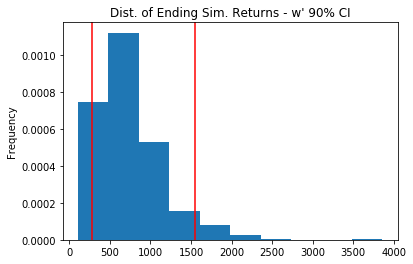

In [42]:
# Visualize the distribution of the ending returns
plt.figure();
ending_cumulative_returns.plot(kind='hist', density=True, bins=10,title="Dist. of Ending Sim. Returns - w' 90% CI")
plt.axvline(confidence_interval.iloc[0], color='r')
plt.axvline(confidence_interval.iloc[1], color='r');

---

## Retirement Analysis

In this section, you will use the monte carlo model to answer the following retirement planning questions:

1. What are the expected cumulative returns at `30` years for the `10th`, `50th`, and `90th` percentiles?

2. Given an initial investment of `$20,000`, what is the expected return in dollars at the `10th`, `50th`, and `90th` percentiles?

3. Given the current projected annual income from the Plaid analysis, will a `4%` withdrawal rate meet or exceed that value at the `10th` percentile? Note: This is basically determining if retirement income is equivalent to current income.

4. How would a `50%` increase in the initial investment amount affect the `4%` retirement withdrawal? In other words, what happens if the initial investment had been bigger?

### What are the expected cumulative returns at 30 years for the 10th, 50th, and 90th percentiles?

In [43]:
# Compute cumulative returns
mul_percentiles = ending_cumulative_returns.quantile(q=[0.1, 0.5, .9])


### Given an initial investment of `$20,000`, what is the expected portfolio return in dollars at the 10th, 50th, and 90th percentiles?

In [44]:
# Set initial investment
initial_investment = 20000

# Compute expected portfolio return
# Calculate investment profit/loss of lower and upper bound cumulative portfolio returns
ten_per_inv = initial_investment * mul_percentiles.iloc[0]
print(ten_per_inv)

fif_per_inv = initial_investment * mul_percentiles.iloc[1]
print(fif_per_inv)

nin_per_inv = initial_investment * mul_percentiles.iloc[2]
print(nin_per_inv)


6740750.111023967
12911841.973219749
24761795.484021146


In [45]:
# Print the results
print(f"The expected cumulative return"
      f" over the next 30 years at the 10th percentile is:"
      f" ${ten_per_inv}")

The expected cumulative return over the next 30 years at the 10th percentile is: $6740750.111023967


In [46]:
# Print the results
print(f"The expected cumulative return"
      f" over the next 30 years at the 50th percentile is:"
      f" ${fif_per_inv}")

The expected cumulative return over the next 30 years at the 50th percentile is: $12911841.973219749


In [47]:
# Print the results
print(f"The expected cumulative return"
      f" over the next 30 years at the 90th percentile is:"
      f" ${nin_per_inv}")

The expected cumulative return over the next 30 years at the 90th percentile is: $24761795.484021146


### Given the current projected annual income from the Plaid analysis, will a 4% withdraw rate from the retirement portfolio meet or exceed that value at the 10th percentile?

Note: This is effectively saying that 90% of the expected returns will be greater than the return at the 10th percentile, so this can help measure the uncertainty about having enough funds at retirement

In [48]:
# Set Plaid's projected income

# Calculate the 4% withdrawal for the ending return as retirement income
# He should have plenty of cash to carry him through retirement if the cumulative return at the 10th percentile is $6.7 million.


### How would a 50% increase in the initial investment amount affect the 4% retirement withdrawal?

In [49]:
# Re-calculate the retirement income with a 50% increase in the initial investment amount
# He should be very comfortable.

### Optional Challenge

Use the Monte Carlo data and calculate the cumulative returns at the `5%`, `50%`, and `95%` quartiles and plot this data as a line chart to see how the cumulative returns change over the life of the investment.

In this section, you need to calculate and plot the cumulative returns for the median and `90%` confidence intervals. This plot shows the expected cumulative returns for any given day between the first day and the last day of investment. 

In [50]:
# Compute projected returns

# Display sample data


In [51]:
# Plot the cumulative returns over time


In [52]:
# Compute portfolio performance over time

# Plot projected performance over time
